### Very Simple Example (single reaction)

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
from scipy.integrate import solve_ivp, odeint

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)

In [2]:
# Define the system of ODEs
def model(y, t, k1, k2):
    dy1dt = -k1 * y[0]
    dy2dt = k1 * y[0] - k2 * y[1]
    return [dy1dt, dy2dt]

y0 = [1, 0]  # Initial conditions
T_START = 0
T_END = 2
t = np.linspace(T_START, T_END, 100)  # Adjust the time range as needed
k1 = 5
k2 = 1
solution = odeint(model, y0, t, args=(k1,k2))

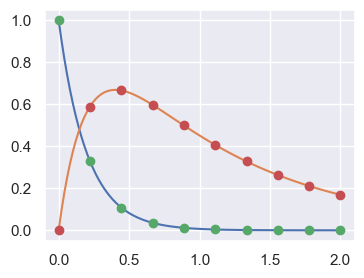

In [3]:
# Analytic ODE solution
z_1 = lambda t: np.exp(-5 * t)
z_2 = lambda t: 5/4 * np.exp(-5 * t) * (-1 + np.exp(4 * t))

# Create true data
t_true = torch.from_numpy(t).float().view(-1,1).to(DEVICE)
y_true = torch.from_numpy(solution).float().to(DEVICE)

# Make training data
n_samples = 10
t_train = torch.linspace(T_START, 2, n_samples).view(-1,1).requires_grad_(True).to(DEVICE)
y_train_1 = z_1(t_train.cpu().detach().numpy())
y_train_2 = z_2(t_train.cpu().detach().numpy())
# Stack the two solutions using numpy 
y_train = np.hstack((y_train_1, y_train_2))

# Plot true and training data 
plt.figure(figsize=(4,3))
plt.plot(t_true.cpu().numpy(), y_true .cpu().numpy())
plt.plot(t_train.cpu().detach().numpy(), y_train[:,0], 'o')
plt.plot(t_train.cpu().detach().numpy(), y_train[:,1], 'o')
plt.show()

In [4]:
# Make a NN for u
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 10)
        self.fc3 = nn.Linear(10, 2)
        
        self.k2 = nn.Parameter(torch.tensor([1.0]))
        self.k1 = nn.Parameter(torch.tensor([1.0]))
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True).float().to(DEVICE)
us_train = torch.tensor(y_train, requires_grad=True).float().to(DEVICE)

/tmp/ipykernel_31279/3687197062.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts_train = torch.tensor(t_train, requires_grad=True).float().to(DEVICE)


In [6]:
def residuals(t, model: nn.Module):
    t = torch.linspace(T_START, T_END, 500).view(-1,1).to(DEVICE)
    t.requires_grad = True  
    u = model(t).to(DEVICE)
    u_t_1  = torch.autograd.grad(u[:,0], t, grad_outputs=torch.ones_like(u[:,0]), create_graph=True)[0]
    u_t_2  = torch.autograd.grad(u[:,1], t, grad_outputs=torch.ones_like(u[:,1]), create_graph=True)[0]
    error_1 = u_t_1 - (-model.k1 * u[:,0])
    error_2 = u_t_2 - (model.k1 * u[:,0] - model.k2 * u[:,1])
    e_1 = torch.mean(error_1)
    e_2 = torch.mean(error_2)
    return e_1**2+e_2**2

In [7]:
network = Network().to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
criterion = nn.MSELoss()

EPOCHS = 20000
LOSS = []
for epoch in range(EPOCHS):
    
    u_pred = network.forward(ts_train)
    residual_pred = residuals(ts_train, network)
    
    loss = criterion(u_pred, us_train)
    loss += torch.mean(residual_pred**2)
    
    LOSS.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{EPOCHS}] Loss: {loss}, k1: {network.k1.item()}, k2: {network.k2.item()}')
        

Epoch [0/20000] Loss: 0.12009134143590927, k1: 0.9990000128746033, k2: 0.9990000128746033
Epoch [500/20000] Loss: 0.011879541911184788, k1: 1.5174245834350586, k2: 0.8064123392105103
Epoch [1000/20000] Loss: 0.002702882280573249, k1: 2.028319835662842, k2: 0.6164446473121643
Epoch [1500/20000] Loss: 0.0013392422115430236, k1: 2.4048125743865967, k2: 0.5441961884498596
Epoch [2000/20000] Loss: 0.0007458335603587329, k1: 2.7078423500061035, k2: 0.5877893567085266
Epoch [2500/20000] Loss: 0.00045402091927826405, k1: 2.9808080196380615, k2: 0.6512338519096375
Epoch [3000/20000] Loss: 0.0002915175864472985, k1: 3.2272276878356934, k2: 0.7016693353652954
Epoch [3500/20000] Loss: 0.00018838487449102104, k1: 3.4483139514923096, k2: 0.7410394549369812
Epoch [4000/20000] Loss: 0.00011816195910796523, k1: 3.646864891052246, k2: 0.7722699046134949
Epoch [4500/20000] Loss: 7.103998359525576e-05, k1: 3.825326442718506, k2: 0.79774409532547
Epoch [5000/20000] Loss: 4.1671490180306137e-05, k1: 3.98543

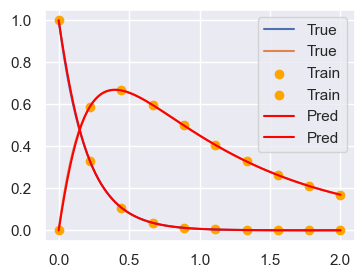

In [8]:
# Plot u_pred vs ts
network.eval()
with torch.no_grad():
    u_pred = network(t_true)
    plt.figure(figsize=(4,3))
    plt.plot(t_true.cpu(), y_true.cpu(), label='True')
    plt.scatter(t_train.cpu(), y_train[:,0], label='Train', color='orange')
    plt.scatter(t_train.cpu(), y_train[:,1], label='Train', color='orange')
    plt.plot(t_true.cpu(), u_pred[:,0].cpu().numpy(), label='Pred', color='red')
    plt.plot(t_true.cpu(), u_pred[:,1].cpu().numpy(), label='Pred', color='red')
    plt.legend()
    plt.show()

In [9]:
network.k1, network.k2

(Parameter containing:
 tensor([4.9105], requires_grad=True),
 Parameter containing:
 tensor([0.9892], requires_grad=True))

### Simple Regression

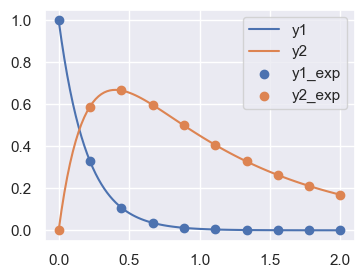

In [42]:
# Define the system of ODEs
def model(y, t, k1, k2):
    dy1dt = -k1 * y[0]
    dy2dt = k1 * y[0] - k2 * y[1]
    return [dy1dt, dy2dt]

y0 = [1, 0]  # Initial conditions
T_START = 0
T_END = 2
t = np.linspace(T_START, T_END, 100)  # Adjust the time range as needed
k1 = 5
k2 = 1
solution = odeint(model, y0, t, args=(k1,k2))

# Analytic ODE solution
z_1 = lambda t: np.exp(-5 * t)
z_2 = lambda t: 5/4 * np.exp(-5 * t) * (-1 + np.exp(4 * t))
 
t_train = np.linspace(T_START, T_END, 10)  
y_train = np.column_stack((z_1(t_train), z_2(t_train)))

# Plot true and training data
plt.figure(figsize=(4,3))
plt.plot(t, solution, label=['y1','y2'])
plt.scatter(x=t_train, y=y_train[:,0], label='y1_exp')
plt.scatter(x=t_train, y=y_train[:,1], label='y2_exp')
plt.legend()
plt.show()